# Engenharia de Prompt decolando Agentes
Nesse artigo entenderemos como um prompt estruturado, mesclado a agentes de inteligência virtual, pode criar uma ferramenta poderozíssima. A proposta é criar um componente que, a partir da transcrição da fala, consiga interpretar dados importantes para uma viagem, e, assim, realizar buscas em servidores de viagens aéreas e de hospedagens, utilizando APIs e **Protocolo MCP**.



### Tópicos abordados:


1.   Transcrição de áudio com Whisper
2.   Estruturação de prompt com Pydantic
3.   Extrair informações com LLM e Engenharia de Prompt
4.   Pesquisas de passagens áreas com a API Amadeus
5.   Pesquisas de hospedagens com servidor MCP da Airbnb
6.   Estrutura de grafos com LangGraph

Com esses capítulos você poderá praticar seus conhecimentos sobre: Transcrição de áudio com Inteligência Artificial; Modelos estruturados com Pydantic; LLMs com LangChain; Manipulação de dados em JSON; Como consumir APIs Restful; Estruturação em grafos com LangGraph.









### 1 - Transcritor com Whisper

Whisper é um modelo, desenvolvido pela OpenAI, especializado em transcrever. A instalação local é simples, necessitando da ferramenta FFmpeg, mas se preferir, utilize outro modelo de transcrição de áudio, nesse Jupyter iremos abstrair a transcrição. Documentação: [Whisper](https://github.com/openai/whisper)



Se preferir, pesquise por APIs de custo por consumo. Segue a instalação em Linux:

```
!sudo apt update && sudo apt install ffmpeg
!pip install git+https://github.com/openai/whisper.git
```

Com isso, podemos rodar Whisper localmente usando

```
!whisper <caminho.mp3> --model small --language pt
```
...ou por meio do interpretador Python (nosso caso):



```
import whisper
import time

def transcritor(audio_path):
    start_time = time.time()

    model = whisper.load_model("small")  
    result = model.transcribe(audio_path)

    print(f'Audio transcrito: {result['text']}\n Tempo de execução: {time.time() - start_time:.2f} segundos.')

    return result["text"]
```






## 2, 3 - Estruturação de Prompt com Pydantic e LLMs na extração de dados
Dentro da biblioteca Pydantic, vamos utilizar a classe BaseModel para criar nosso modelo, esse, por sua vez, será responsável por estruturar atributos, importatantes para nossas pesquisas, em uma classe, facilitando a manipulação desses atributos. Documentação: [PyDantic](https://docs-pydantic-dev.translate.goog/latest/?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=tc)

Para isso, teremos uma classe `InformacoesVoo`, que herda o `BaseModel` e organiza os atributos:

In [ ]:
# !pip install pydantic --quiet
from pydantic import BaseModel, Field
from typing import Optional

class InformacoesVoo(BaseModel):
    """Estrutura para armazenar informações de uma solicitação de voo."""
    originLocationCode: str = Field(description="O código de 3 digitos do aeroporto de partida do voo seguindo o padrão IATA.")
    destinationLocationCode: str = Field(description="O código de 3 digitos do aeroporto de destino do voo seguindo o padrão IATA.")
    departureDate: str = Field(description="A data de ida da viagem, no formato YYYY-MM-DD.")
    returnDate: Optional[str] = Field(None, description="A data de volta da viagem, se especificada. Formato YYYY-MM-DD.")
    maxPrice: Optional[int] = Field(None, description="O orçamento máximo para a viagem.")
    adults: int = Field(1, description="O número de passageiros para a viagem.")
    currencyCode: str = Field('BRL', description="A moeda utilizada na transação.")
    nonStop: Optional[str] = Field('true', description="Se o voo é sem paradas ('true') ou com escalas ('false').")

Note que conseguimos definir descrições e a obrigatoriedade dos campos, utilizaremos isso para orientar nosso agente posteriormente. Além disso, ponderei atributos com nomenclaturas baseadas na estruturação da pesquisa na API de passagens aéreas Amadeus, daqui a pouco isso ficará mais claro.

Após ter criado nosso modelo de prompt, vamos criar uma função para manipulá-lo, essa será chamada de `prompt_template()`. Ela permitirá absorver as informações da melhor forma possível, para aplicarmos em nosso agente.
Para isso, utilizarei a classe PromptTemplate do Langchain. Ela cria um escopo, o qual poderei construir um contexto dinâmico que pode assumir parâmetros.

In [ ]:
# !pip install langchain --quiet
from langchain.prompts import PromptTemplate

def prompt_template():
    prompt_template = """
    Você é um assistente especializado em extrair informações de voos a partir de um texto. Sua tarefa é analisar cuidadosamente a solicitação do usuário, resolver ambiguidade de locais, interpretar corretamente fusos horários e formatar a resposta em JSON conforme o modelo fornecido.

    Hoje é {date}. Utilize essa informação para inferir datas relativas (como "semana que vem" ou "amanhã").

    ---

    📌 **Instruções de Interpretação:**

    1. **Local de partida e destino**:
    - Sempre retorne **códigos dos aeroportos** seguindo o padrão IATA em 3 digitos.
        Exemplo: `NYC`
    - Se o usuário mencionar um **estado**, **região** ou **país**, extraia o **codigo do aeroporto referencia**.

    2. **Moeda**:
    - Identifique a moeda (ex: "dólares", "euros") a partir das informações do texto, como o idioma e localizações, extraia a moeda e normalize no formato:
        **`Código da Moeda`**
        Exemplo: `USD`
    - Se nenhuma moeda for mencionada, use `BRL` como padrão (Real Brasileiro).

    3. **Orçamento, passageiros**:
    - Extraia números inteiros sempre que possível. Se o número de passageiros não for especificado, por padrão é 1.

    4. **Voo direto ou com escalas**:
    - Se o usuário mencionar que deseja um voo direto, defina `semParada` como `'true'`. Caso contrário, defina como `'false'`.
    ---

    📦 **Formato de Resposta Esperado (em JSON):**
    {format_instructions}

    ---

    📝 **Texto do Usuário:**
    {input}

    ---

    ✅ **Sua Resposta JSON:**
    """

    return PromptTemplate(
        input_variables= ["input","format_instructions","date"],
        template=prompt_template,
    )

Note como podemos passar instruções detalhando como queremos que seja extraído e tratado os nossos atributos. Esta função retorna uma classe do tipo PromptTemplate, ela possui como base o template que formamos e espera três entradas: `["input","format_instructions","date"]`

*   **input**: Será o texto pelo qual extrairemos os atributos (nossa entrada)
*   **format_instructions**: Instruções geradas automaticamente a partir das descrições dos atributos de InformacoesVoo
*   **date**: A data atual

Após isso, podemos instanciar nosso prompt passando os parâmetros certos:

In [ ]:
# !pip install langchain_core --quiet
from datetime import date
from langchain_core.output_parsers import PydanticOutputParser

pydantic_parser = PydanticOutputParser(pydantic_object=InformacoesVoo)

# Parâmetros para nosso prompt:
input = 'quero ir de natal para sao paulo na proxima sextafeira'
format_instructions = pydantic_parser.get_format_instructions()

# .format() é um método de PromptTemplate que faz por nós o trabalho de associar as variáveis ao prompt
prompt = prompt_template().format(input=input, format_instructions=format_instructions, date=date.today())
print(prompt)


    Você é um assistente especializado em extrair informações de voos a partir de um texto. Sua tarefa é analisar cuidadosamente a solicitação do usuário, resolver ambiguidade de locais, interpretar corretamente fusos horários e formatar a resposta em JSON conforme o modelo fornecido.

    Hoje é 2025-08-19. Utilize essa informação para inferir datas relativas (como "semana que vem" ou "amanhã").

    ---

    📌 **Instruções de Interpretação:**

    1. **Local de partida e destino**:
    - Sempre retorne **códigos dos aeroportos** seguindo o padrão IATA em 3 digitos.
        Exemplo: `NYC`
    - Se o usuário mencionar um **estado**, **região** ou **país**, extraia o **codigo do aeroporto referencia**.

    2. **Moeda**:
    - Identifique a moeda (ex: "dólares", "euros") a partir das informações do texto, como o idioma e localizações, extraia a moeda e normalize no formato:
        **`Código da Moeda`**
        Exemplo: `USD`
    - Se nenhuma moeda for mencionada, use `BRL` como padrão

Por fim, podemos configurar uma LLM e passar nosso prompt. No meu caso, optei pelo `gemini-2.5-pro` do Google, utilizando a biblioteca LangChain. Se quiser saber mais sobre agentes encadeados, veja a documentação oficial: [LangChain Docs](https://python.langchain.com/docs/introduction)

In [ ]:
# !pip install langchain_google_genai --quiet
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata

llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", api_key=userdata.get('GENAI_KEY'))
chain = llm | pydantic_parser

try:
    texto_extraido = chain.invoke(prompt).model_dump()
    print(texto_extraido)

except Exception as e:
    print(Exception(f"Ocorreu um erro ao processar a solicitação: {e}"))

{'originLocationCode': 'NAT', 'destinationLocationCode': 'SAO', 'departureDate': '2025-08-29', 'returnDate': None, 'maxPrice': None, 'adults': 1, 'currencyCode': 'BRL', 'nonStop': 'false'}


Com isso, nosso agente extrator está completo! Note que sua saída é um dicionário que encaixará perfeitamente com a AmadeusAPI.

## 4 - Pesquisas de passagens áreas com a API Amadeus
Amadeus API é uma API (Application Programming Interface) para pesquisas de passagens aéreas. Em sua documentação oficial você terá acesso a sua própria *api_key*, além de ter acesso a uma interface *RestfulApi*, que o permitirá testar e conhecer a API de forma documentada. Documentação: [AmadeuAPI](https://developers.amadeus.com)

A conexão com AmadeusAPI segue dois paços:


1.   Requisição com chaves de acesso para obter um token de acesso.
2.   Pesquisas utilizando o token de acesso

... para isso, utilizaremos a biblioteca `requests` para fazer as requisições necessárias.


In [ ]:
import requests
from google.colab import userdata

# Chaves de acesso
API_KEY = userdata.get('AMADEUS_API')
API_SECRET = userdata.get('AMADEUS_SECRET')

# URL e Headers para a requisição
url_request_token = f'https://test.api.amadeus.com/v1/security/oauth2/token'
headers_access_token = {
    "Content-Type" : "application/x-www-form-urlencoded",
    # "Authorization": "Bearer TOKEN"
}

data_access_token = {
    "grant_type":"client_credentials",
    "client_id": API_KEY,
    "client_secret": API_SECRET
}
res = requests.post(url_request_token, headers=headers_access_token, data=data_access_token)

# Tratando a resposta para adquirir o token
access_token = res.json()['access_token']

Com nosso token de acesso, já podemos montar nossa requisição utilizando a resposta do nosso agente extrator. Prevendo esse passo, montamos o prompt para encaixar perfeitamente na AmadeusAPI, como mostra o exemplo abaixo da documentação RestFul:
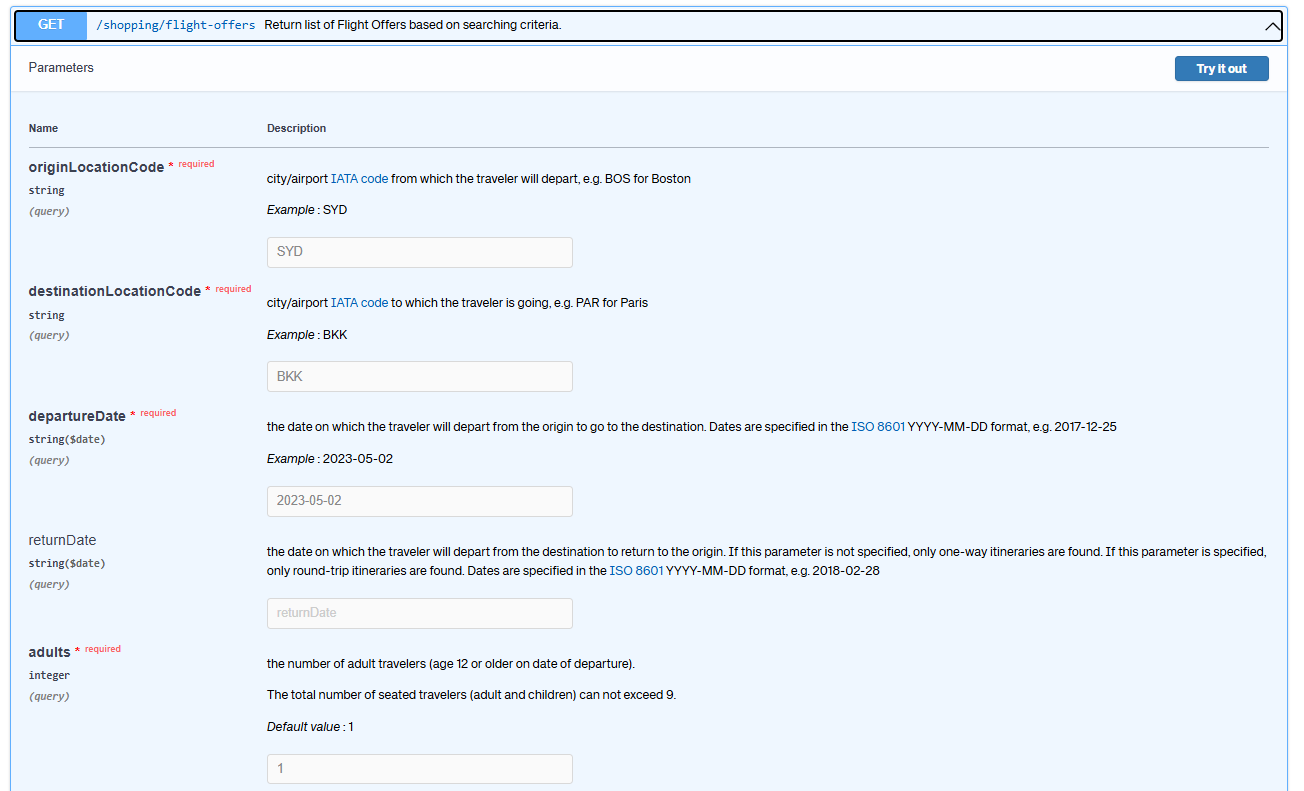

Logo, podemos fazer nossa pesquisa por vôos:

In [ ]:
import json # Usaremos o json.dupms() para imprimir a resposta com identação formatada

base_url = "https://test.api.amadeus.com/v2"

# Definindo o limite de resultados
texto_extraido['max'] = 3

headers = {
    "Authorization": f'Bearer {access_token}'
}

passagens = requests.get(f'{base_url}/shopping/flight-offers', params=texto_extraido, headers=headers)

passagens = passagens.json()
print(json.dumps(passagens, indent=4))

{
    "meta": {
        "count": 3,
        "links": {
            "self": "https://test.api.amadeus.com/v2/shopping/flight-offers?originLocationCode=NAT&destinationLocationCode=SAO&departureDate=2025-08-29&adults=1&currencyCode=BRL&nonStop=false&max=3"
        }
    },
    "data": [
        {
            "type": "flight-offer",
            "id": "1",
            "source": "GDS",
            "instantTicketingRequired": false,
            "nonHomogeneous": false,
            "oneWay": false,
            "isUpsellOffer": false,
            "lastTicketingDate": "2025-08-29",
            "lastTicketingDateTime": "2025-08-29",
            "numberOfBookableSeats": 7,
            "itineraries": [
                {
                    "duration": "PT3H35M",
                    "segments": [
                        {
                            "departure": {
                                "iataCode": "NAT",
                                "at": "2025-08-29T13:05:00"
                          

## 5 - Pesquisas de hospedagem na Airbnb com protocolo MCP
O protocolo MCP é uma forma dinâmica de fornecer contexto aumentado para agentes de IA. O Airbnb oferece tal serviço em seu [repositório oficial](https://github.com/openbnb-org/mcp-server-airbnb).

Para consumir o servidor MCP da Airbnb, precisamos rodar um MCP Client após instalar as dependências do repositório oficial.

In [ ]:
!npm install git@github.com:openbnb-org/mcp-server-airbnb.git

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇
up to date, audited 118 packages in 2s
⠇
⠇36 packages are looking for funding
⠇  run `npm fund` for details
⠇
found 0 vulnerabilities
⠇

In [ ]:
!npx @openbnb/mcp-server-airbnb

⠙[2025-08-20T14:26:30.969Z] [INFO] Airbnb MCP Server starting: {
  "version": "0.1.3",
  "ignoreRobotsTxt": false,
  "nodeVersion": "v20.19.0",
  "platform": "linux"
}
[2025-08-20T14:26:30.971Z] [INFO] Fetching robots.txt from Airbnb
[2025-08-20T14:26:31.125Z] [INFO] Successfully fetched robots.txt
[2025-08-20T14:26:31.126Z] [INFO] Airbnb MCP Server running on stdio: {
  "version": "0.1.3",
  "robotsRespected": true
}
[2025-08-20T14:26:33.096Z] [INFO] Received SIGINT, shutting down gracefully
^C


Caso isso não funcione, baixe os arquivos do repositório diretamente na raíz do seu projeto (onde o interpretador Python será executado) e instale as dependências: `npm install @openbnb/mcp-server-airbnb`

Com isso, já temos um MCP Client acessível, podemos acessá-lo através de scripts em Python.

Obs.: Os próximos scripts não serão executáveis por limitações do Jupyter.


```
# !pip install mcp
import json
from contextlib import AsyncExitStack

from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client

async with AsyncExitStack() as stack:

    # Inicializando e configurando o MCP Client
    server_params = StdioServerParameters(command="npx", args=["-y", "@openbnb/mcp-server-airbnb", "--ignore-robots-txt"])
    stdio_transport = await stack.enter_async_context(stdio_client(server_params))
    stdio, write = stdio_transport
    client = await stack.enter_async_context(ClientSession(stdio, write))
    await client.initialize()
    
    # Fazendo a pesquisa
    search_query = {'location': 'sao paulo'}
    response = await client.call_tool("airbnb_search", search_query)
   
    # Formatando a saída
    messages = []
    count = 0
    for item in json.loads(response.content[0].text)['searchResults']:
        messages.append(item)
        count += 1
        if count >= max:
            break

    print(messages)

```



Exemplo de saída:

```
{
            "id": "1451006332213323385",
            "url": "https://www.airbnb.com/rooms/1451006332213323385",
            "demandStayListing": {
                "id": "RGVtYW5kU3RheUxpc3Rpbmc6MTQ1MTAwNjMzMjIxMzMyMzM4NQ==",
                "description": {
                    "name": {
                        "localizedStringWithTranslationPreference": "Cabana HouseLander"
                    }
                },
                "location": {
                    "coordinate": {
                        "latitude": -22.7892,
                        "longitude": -45.7433
                    }
                }
            },
            "badges": "",
            "structuredContent": {
                "mapCategoryInfo": "",
                "mapSecondaryLine": "",
                "primaryLine": "1 bed",
                "secondaryLine": ""
            },
            "avgRatingA11yLabel": "5.0 out of 5 average rating,  4 reviews",
            "structuredDisplayPrice": {
                "primaryLine": {
                    "accessibilityLabel": "R$445 for 1 night, originally R$772"
                },
                "explanationData": {
                    "title": "Price details",
                    "priceDetails": "1 night x R$444.03: R$444.03, "
                }
            }
        },
        {
            "id": "1470274148367820614",
            "url": "https://www.airbnb.com/rooms/1470274148367820614",
            "demandStayListing": {
                "id": "RGVtYW5kU3RheUxpc3Rpbmc6MTQ3MDI3NDE0ODM2NzgyMDYxNA==",
                "description": {
                    "name": {
                        "localizedStringWithTranslationPreference": "Madre Terra Cabin"
                    }
                },
                "location": {
                    "coordinate": {
                        "latitude": -27.63182,
                        "longitude": -48.92279
                    }
                }
            },
            "badges": "",
            "structuredContent": {
                "mapCategoryInfo": "",
                "mapSecondaryLine": "",
                "primaryLine": "1 bed",
                "secondaryLine": ""
            },
            "avgRatingA11yLabel": "New place to stay",
            "structuredDisplayPrice": {
                "primaryLine": {
                    "accessibilityLabel": "R$857 for 1 night"
                },
                "explanationData": {
                    "title": "Price details",
                    "priceDetails": "1 night x R$856.45: R$856.45"
                }
            }
        },
        {
            "id": "1473296071395384142",
            "url": "https://www.airbnb.com/rooms/1473296071395384142",
            "demandStayListing": {
                "id": "RGVtYW5kU3RheUxpc3Rpbmc6MTQ3MzI5NjA3MTM5NTM4NDE0Mg==",
                "description": {
                    "name": {
                        "localizedStringWithTranslationPreference": "Cabin in Alto Boquete 1"
                    }
                },
                "location": {
                    "coordinate": {
                        "latitude": 8.6933,
                        "longitude": -82.4475
                    }
                }
            },
            "badges": "",
            "structuredContent": {
                "mapCategoryInfo": "",
                "mapSecondaryLine": "",
                "primaryLine": "3 beds",
                "secondaryLine": ""
            },
            "avgRatingA11yLabel": "New place to stay",
            "structuredDisplayPrice": {
                "primaryLine": {
                    "accessibilityLabel": "R$513 for 1 night, originally R$623"
                },
                "explanationData": {
                    "title": "Price details",
                    "priceDetails": "1 night x R$622.07: R$622.07, Special offer: -R$109.98, Price after discount: R$512.09, "
                }
            }
        }
```


## 6 - Estruturando um fluxo de Grafos com LangGraph
Agora, basta criar um fluxo com todas as nossas ferramentas, utilizando LangGraph e suas dependências. Documentação: [LangGraph](https://langchain-ai.github.io/langgraph/concepts/why-langgraph).
O fluxo de grafos funcionará melhor com a Estruturação de Arquivos em módulos Python, ficando visivelmente mais fácil de compreender pelo repositório original deste projeto. Segue o [link](https://github.com/ricken-diniz/vozia). Ficará abaixo apenas a explicação do código, aproveite!

Assuma os métodos: ` get_attributes, transcritor, search_flights e airbnb_search `, como componentes que encapsulam as funcionalidades implementadas neste tutorial, caso dúvidas, veja o repositório do projeto.

Principais importações:

```
import json

# Componentes para a estruturação do grafo
from langgraph.graph import StateGraph, START, END

# Componentes para a estruturação dos nós e a manipulação das respostas/dados
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated
```

Iremos definir uma classe State(TypedDict), ela remete um dicionário estruturado e cada nó de nosso grafo irá herdar as características dela.
Nosso grafo (do LangGraph) irá interpretar essa estrutura de dicionário e manipular eficientemente nossos nós, sabendo adequadamente o que passar e receber como resposta em cada *step* (passo).

```
class State(TypedDict):
    messages: Annotated[list, add_messages]
    content: dict
    flightsContent: dict
    airbnbContent: dict
```

Agora, podemos definir os métodos que irão representar nossos nós, com suas determinadas saídas, e, também, nosso grafo:



```
def process_audio(state: State):
    informations = get_attributes(transcritor(state['messages'][0].content))
    return {"content": informations}

def search_in_airbnb(state: State):
    return {"airbnbContent": asyncio.run(airbnb_search(state['content']['host']))}

def search_in_flights(state: State):
    return {"flightsContent": search_flights(state['content']['flight'])}

def get_response(state: State):
    return {'messages': [{
        'role': 'assistant',
        'content': [{
            'airbnb_results': state['airbnbContent'],
            'flight_results': state['flightsContent']
        }]
    }]}

graph_builder = StateGraph(State)
```



Com os grafos e nós definidos, precisamos apenas montar o quebra cabeça, adicionando os nós (os métodos definidos) ao grafo e definindo a ligação entre eles (edges). Note que no nosso exemplo existe uma bifurcação e um *fork*, para que, após a extração, passe pelos dois nós de pesquisa e posteriormente traga um resultado.



```
graph_builder.add_node('process_audio', process_audio)
graph_builder.add_node("search_airbnb", search_in_airbnb)
graph_builder.add_node("search_flights", search_in_flights)
graph_builder.add_node('get_response', get_response)

graph_builder.add_edge(START, 'process_audio')
graph_builder.add_edge('process_audio', "search_airbnb")
graph_builder.add_edge('process_audio', "search_flights")
graph_builder.add_edge("search_airbnb", 'get_response')
graph_builder.add_edge("search_flights", 'get_response')
graph_builder.add_edge('get_response', END)
```



Finalmente, podemos compilar e executar nosso grafo. Nesta estrutura, passamos o método principal com o caminho do áudio a ser transcrito. Se quiser aprender mais sobre estruturas de grafos com LangGraph, veja a [documentação oficial](https://langchain-ai.github.io/langgraph/concepts/why-langgraph/).



```
graph = graph_builder.compile()

def stream_graph_updates(audio_path: str):
    for event in graph.stream({"messages": [{'role': 'user', 'content': audio_path}]}):
        for value in event.values():
            print("Assistant:", json.dumps(value, indent=4), '/n')

if __name__ == "__main__":
    stream_graph_updates('audioteste.mp3')
```



### Considerações

Este é o fim deste artigo, espero que tenha aproveitado e absorvido conhecimentos! Se tiver interesse no projeto, divulgue fornecendo os créditos.

- Contatos:

Email: dinizrickenn@gmail.com

LinkedIn: www.linkedin.com/in/ricken-diniz

GitHub: www.github.com/ricken-diniz

Repositório do Projeto: www.github.com/ricken-diniz/vozia
